<a href="https://colab.research.google.com/github/amunwes/Elec-400M/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW3
Andrew Munro-West #18363572

# Neural Network In Pytorch
This assignment aims to get familiarized with building the whole pipeline of deep learning in Pytorch to perform classification and test it out on the MINIST dataset. All the code will be implemented in this notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


First, let's install modules not already installed by Google Colab.

## Task 1: Design the Neural Network and Data Preparation


In the beginning, please import all the packages you need. We provide some packages here, which might be helpful when you build your code.

In [ ]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import cuda
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, sampler
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from numpy import inf


from sklearn.model_selection import train_test_split
import os
from glob import glob
from torchvision import datasets, transforms
from torchvision import models
from torch import optim, cuda, Tensor
import tqdm

# Data science tools
import numpy as np
import random

import os

# Image manipulations
from PIL import Image
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
#plt.rcParams['font.size'] = 14

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
np.random.seed(0)
torch.manual_seed(0)

###Network Design
Then, we need to define a class for your network. The network should include two linear layer, one Relu layer, and one dropout layer.

In [ ]:
# define model
class bmodel(nn.Module):
    def __init__(self, input_d, hidden_d, output_d):
        super().__init__()
        # Define all the layers that you need in your network
        # You can use nn.Linear() to define the linear layer
        # nn.Dropout() to define the dropout layer
        # F.relu() to define your ReLu layer
        ######################
        ### YOUR CODE HERE ###
        ######################
        self.l0 =  nn.Linear(input_d, hidden_d)
        self.l1 =  nn.Linear(hidden_d, output_d)
        self.dropout = nn.Dropout(0.1)
        #####################
        ### YOUR CODE END ###
        #####################

    def forward(self, x):
        output = torch.flatten(x,1)
        output = self.l0(output)
        output = self.dropout(output)
        output = F.relu(output)
        output = self.l1(output)

        return output



Now, we can design our toy model to test your network.

In [ ]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return bmodel(input_size, hidden_size, num_classes)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

toy_model = init_toy_model()
train_X, train_Y = init_toy_data()
validation_X, validation_Y = init_toy_data()

Cuda is Compute Unified Device Architecture, which can achieve parallel computing. It will improve our learning speed in the parameter update by using GPU rather than CPU.

In [ ]:
# Check whether there is a gpu for cuda
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False
else:
    multi_gpu = False
print(train_on_gpu,multi_gpu)

Train on gpu: True
1 gpus detected.
True False


###Data Preparation
Next, we need to organize the data before we load them into the network. In Pytorch, we use Tensor as the data structure for computing, and we use "dataloaders" to achieve mini-batch from the whole dataset.

In [ ]:
# Datasets organization
batch_size = 1

# Transfer the data from numpy to tensor
data = {
    'train':
    TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_Y).long()),

    # please define your validation dataset
    ######################
    ### YOUR CODE HERE ###
    ######################
    'valid':
    TensorDataset(torch.from_numpy(validation_X).float(), torch.from_numpy(validation_Y).long())

    #####################
    ### YOUR CODE END ###
    #####################

}


# Dataloader iterators, make sure to shuffle
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True,num_workers=10),
    # please define your validation data loader
    ######################
    ### YOUR CODE HERE ###
    ######################
    'valid': DataLoader(data['valid'], batch_size=batch_size, shuffle=False,num_workers=10)

    ######################
    ### YOUR CODE END ####
    ######################
}



# Iterate through the dataloader once
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(torch.Size([1, 4]), torch.Size([1]))

### Setting Learning Parameters
In our training process, we need to set up the loss function and optimizer tool.

In [ ]:
# Set up your criterion and optimizer
# Please use nn.CrossEntropyLoss() and optim.Adam()
#####################
### YOUR CODE HERE###
#####################
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(toy_model.parameters())

####################
### YOUR CODE END###
####################

for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

torch.Size([10, 4])
torch.Size([10])
torch.Size([3, 10])
torch.Size([3])


## Task 2: Build the Training Pipeline

### Training Process
We are now defining the train function. Please follow the instruction to finish each part.

If you are going to use a GPU

1. make sure you have GPU
2. Convert model to GPU with model = model.cuda()
3. convert training data to GPU with data = data.cuda(); target = target.cuda()

In [ ]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=10,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """
    # model = model.cuda()

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()

        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):

            # Tensors to gpu, both model parameters, data, and target need to be tensors.
            # You can use .cuda() function
            ######################
            ### YOUR CODE HERE ###
            ######################
            data = data.cuda()
            target = target.cuda()

            #####################
            ### YOUR CODE END ###
            #####################

            # Clear gradients
            optimizer.zero_grad()

            # Forward path
            ######################
            ### YOUR CODE HERE ###
            ######################
            # feed data into model, forward function automatically runs on
            # the passed data because of how nn.Module base class is setup

            output = model(data)
            #####################
            ### YOUR CODE END ###
            #####################

            # Loss function
            ######################
            ### YOUR CODE HERE ###
            ######################
            loss = criterion(output, target)


            #####################
            ### YOUR CODE END ###
            #####################

            # Backward path (backpropagation)
            ######################
            ### YOUR CODE HERE ###
            ######################
            loss.backward()

            #####################
            ### YOUR CODE END ###
            #####################

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))

            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():

                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    ######################
                    ### YOUR CODE HERE ###
                    ######################
                    data = data.cuda()
                    target = target.cuda()
                    #####################
                    ### YOUR CODE END ###
                    #####################

                    # Forward path
                    ######################
                    ### YOUR CODE HERE ###
                    ######################
                    output = model(data)
                    #####################
                    ### YOUR CODE END ###
                    #####################

                    # Validation loss computation
                    ######################
                    ### YOUR CODE HERE ###
                    ######################
                    loss = criterion(output, target)

                    #####################
                    ### YOUR CODE END ###
                    #####################

                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                    correct_tensor.type(torch.FloatTensor))

                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)


                # Calculate average losses and Calculate average accuracy
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    # You can use torch.save()
                    ######################
                    ### YOUR CODE HERE ###
                    ######################
                    torch.save(model.state_dict(), save_file_name)
                    #####################
                    ### YOUR CODE END ###
                    #####################

                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch


    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

### Train a Network With Toy Data


Well done! Once we finish our train process design, we can start to train our network with our toy dataset.

In [ ]:
from timeit import default_timer as timer
save_file_name = f'toy_model_best_model.pt'
train_on_gpu = cuda.is_available()

toy_model = toy_model.cuda()
# print(f"model: {next(toy_model.parameters()).is_cuda}")

# criterion = criterion.cuda()

model, history = train(toy_model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['valid'],
    save_file_name=save_file_name,
    n_epochs=300,
    print_every=1.0)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.9701 	Validation Loss: 0.9473
		Training Accuracy: 40.00%	 Validation Accuracy: 40.00%

Epoch: 1 	Training Loss: 0.9387 	Validation Loss: 0.9112
		Training Accuracy: 40.00%	 Validation Accuracy: 40.00%

Epoch: 2 	Training Loss: 0.8113 	Validation Loss: 0.8791
		Training Accuracy: 80.00%	 Validation Accuracy: 60.00%

Epoch: 3 	Training Loss: 0.9813 	Validation Loss: 0.8471
		Training Accuracy: 40.00%	 Validation Accuracy: 60.00%

Epoch: 4 	Training Loss: 0.9177 	Validation Loss: 0.8170
		Training Accuracy: 40.00%	 Validation Accuracy: 60.00%

Epoch: 5 	Training Loss: 1.0262 	Validation Loss: 0.7902
		Training Accuracy: 20.00%	 Validation Accuracy: 60.00%

Epoch: 6 	Training Loss: 0.8425 	Validation Loss: 0.7658
		Training Accuracy: 40.00%	 Validation Accuracy: 60.00%

Epoch: 7 	Training Loss: 0.9530 	Validation Loss: 0.7458
		Training Accuracy: 40.00%	 Validation Accuracy: 60.00%

Epoch: 8 	Training Loss: 0.7222 	Validation Lo

Now, we can check the losses and accuracy during the training.

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

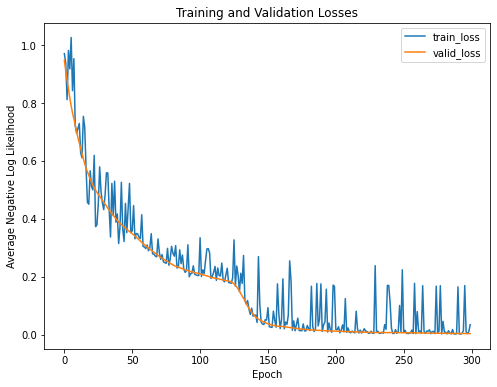

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

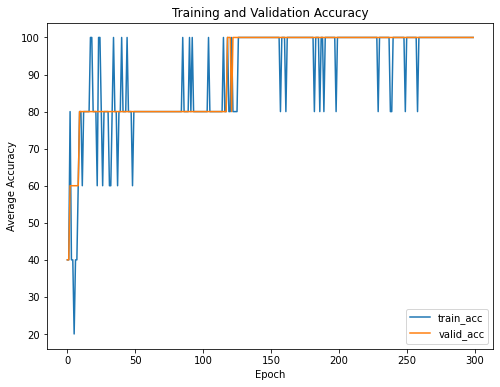

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

## Task 3: Train and Improve The Performance a Network With MINIST Data
Now we may use the MINIST dataset to train our model. First, we will load the MINIST dataset.

In [ ]:
## download and transform the data
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset1 = torch.utils.data.Subset(dataset1, random.sample(range(len(dataset1)), 3000))
## train and valiation split
train_size = int(0.8 * len(dataset1))
val_size = len(dataset1) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset1, [train_size, val_size])

test_dataset = datasets.MNIST('../data', train=False,
                   transform=transform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = 64,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size = 64)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size = 64)


Since MINIST has a larger size of data, which is harder to train, we need to increase our network parameters to solve this task.


In [ ]:
input_size = 28 * 28 * 1
num_classes = 10
# Iterate through the dataloader once
trainiter = iter(train_loader)
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([64, 1, 28, 28]), torch.Size([64]))


Here, we need to modify given network with different set of sequential number and hidden layer dimension pairs [1,128], [2,512] and [6,5000] to see to see how the validation accuracy changes.
For this question, we won't expect to achieve a perfect performance, just to see some results.

---



---



In [ ]:
class Net(nn.Module):
    def __init__(self,num_classes = 10, hidden = 128, N = 1):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.fc1 = nn.Linear(5408, hidden)
        ######################
        ### YOUR CODE HERE ###
        ######################
        layers = [nn.Linear(hidden, hidden),nn.ReLU()]*N     ### fill the number here
        ######################
        ### YOUR CODE HERE ###
        ######################
        self.fcL = nn.Sequential(*layers)
        self.fc2 = nn.Linear(hidden, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fcL(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
 ######################
### YOUR CODE HERE ###
######################
model = Net(num_classes,hidden=128,N=1)

Set up our criterion and optimizer for the new model.

In [ ]:
# Set up your criterion and optimizer
# Please use nn.CrossEntropyLoss() and optim.Adam()
######################
### YOUR CODE HERE ###
######################
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters())

#####################
### YOUR CODE END ###
#####################

Train your new network and get the results. At this time, the training process may need more time.

In [ ]:
from timeit import default_timer as timer
save_file_name = f'MINIST_model_best_model.pt' # the best model path
train_on_gpu = cuda.is_available()

model = model.cuda()

## you can adjust the parameters in the training function
model, history = train(model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    save_file_name=save_file_name,
    n_epochs=30,
    print_every=1)

model_128 = model

Starting Training from Scratch.

Epoch: 0	100.00% complete. 5.03 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.0262 	Validation Loss: 0.5556
		Training Accuracy: 68.38%	 Validation Accuracy: 82.00%
Epoch: 1	100.00% complete. 0.52 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 0.3530 	Validation Loss: 0.3577
		Training Accuracy: 88.96%	 Validation Accuracy: 89.33%
Epoch: 2	100.00% complete. 0.51 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 0.2265 	Validation Loss: 0.2576
		Training Accuracy: 93.38%	 Validation Accuracy: 91.67%

Epoch: 3 	Training Loss: 0.1424 	Validation Loss: 0.2450
		Training Accuracy: 95.88%	 Validation Accuracy: 93.00%

Epoch: 4 	Training Loss: 0.1107 	Validation Loss: 0.1942
		Training Accuracy: 96.92%	 Validation Accuracy: 94.83%

Epoch: 5 	Training Loss: 0.0853 	Validation Loss: 0.2135
		Training Accuracy: 97.96%	 Validation Accuracy: 93.67%

Epoch: 6 	Training Loss: 0.0591 	Validation Loss: 0.2093
		Training Accuracy: 98.71%	 Validation Accuracy

It seems that the process will end very early since there is no progress during the training. Let's print the results.

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

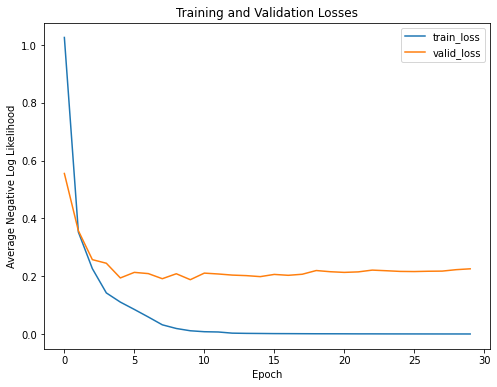

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

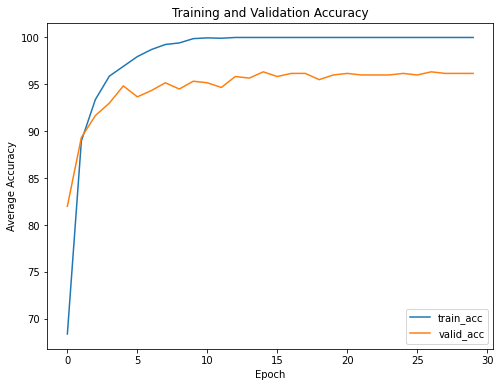

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:

model = Net(num_classes,hidden=512,N=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
from timeit import default_timer as timer
save_file_name = f'MINIST_model_best_model.pt' # the best model path
train_on_gpu = cuda.is_available()

model = model.cuda()

## you can adjust the parameters in the training function
model, history = train(model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    save_file_name=save_file_name,
    n_epochs=30,
    print_every=1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.9703 	Validation Loss: 0.5344
		Training Accuracy: 67.21%	 Validation Accuracy: 83.67%

Epoch: 1 	Training Loss: 0.3442 	Validation Loss: 0.3015
		Training Accuracy: 89.25%	 Validation Accuracy: 92.00%

Epoch: 2 	Training Loss: 0.1886 	Validation Loss: 0.2976
		Training Accuracy: 93.58%	 Validation Accuracy: 89.67%

Epoch: 3 	Training Loss: 0.1254 	Validation Loss: 0.2294
		Training Accuracy: 95.96%	 Validation Accuracy: 94.00%

Epoch: 4 	Training Loss: 0.0722 	Validation Loss: 0.2876
		Training Accuracy: 97.46%	 Validation Accuracy: 92.33%

Epoch: 5 	Training Loss: 0.0571 	Validation Loss: 0.2252
		Training Accuracy: 98.04%	 Validation Accuracy: 95.33%

Epoch: 6 	Training Loss: 0.0321 	Validation Loss: 0.2228
		Training Accuracy: 98.96%	 Validation Accuracy: 94.50%
Epoch: 7	100.00% complete. 0.57 seconds elapsed in epoch.
Epoch: 7 	Training Loss: 0.0156 	Validation Loss: 0.4033
		Training Accuracy: 99.50%	 Validation Accurac

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

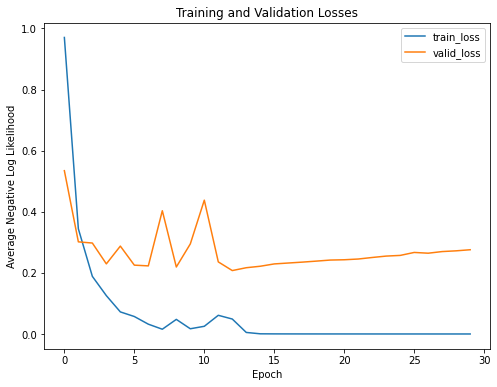

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

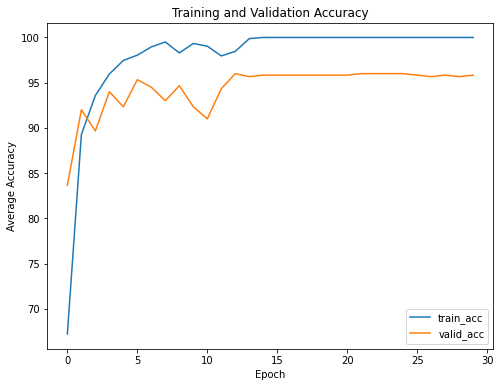

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

In [ ]:

model = Net(num_classes,hidden=5000,N=6)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
from timeit import default_timer as timer
save_file_name = f'MINIST_model_best_model.pt' # the best model path
train_on_gpu = cuda.is_available()

model = model.cuda()

## you can adjust the parameters in the training function
model, history = train(model,
    criterion,
    optimizer,
    train_loader,
    val_loader,
    save_file_name=save_file_name,
    n_epochs=30,
    print_every=1)

Starting Training from Scratch.


Epoch: 0 	Training Loss: 2.7686 	Validation Loss: 2.0619
		Training Accuracy: 11.50%	 Validation Accuracy: 18.00%

Epoch: 1 	Training Loss: 1.8901 	Validation Loss: 1.6922
		Training Accuracy: 19.88%	 Validation Accuracy: 18.00%

Epoch: 2 	Training Loss: 1.5079 	Validation Loss: 1.5123
		Training Accuracy: 28.00%	 Validation Accuracy: 27.50%

Epoch: 3 	Training Loss: 1.3551 	Validation Loss: 1.4230
		Training Accuracy: 36.75%	 Validation Accuracy: 36.33%

Epoch: 4 	Training Loss: 1.1995 	Validation Loss: 1.2656
		Training Accuracy: 46.54%	 Validation Accuracy: 48.83%

Epoch: 5 	Training Loss: 1.0302 	Validation Loss: 1.0868
		Training Accuracy: 55.38%	 Validation Accuracy: 47.17%

Epoch: 6 	Training Loss: 0.7575 	Validation Loss: 0.7544
		Training Accuracy: 64.29%	 Validation Accuracy: 62.17%

Epoch: 7 	Training Loss: 0.6527 	Validation Loss: 0.6350
		Training Accuracy: 73.92%	 Validation Accuracy: 76.50%

Epoch: 8 	Training Loss: 0.4836 	Validation Lo

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Negative Log Likelihood')

Text(0.5, 1.0, 'Training and Validation Losses')

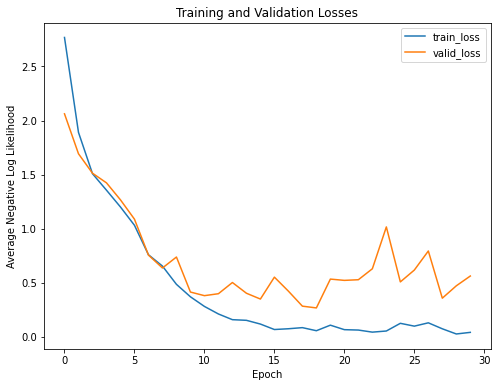

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')
plt.show()

<Figure size 576x432 with 0 Axes>

Text(0.5, 0, 'Epoch')

Text(0, 0.5, 'Average Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

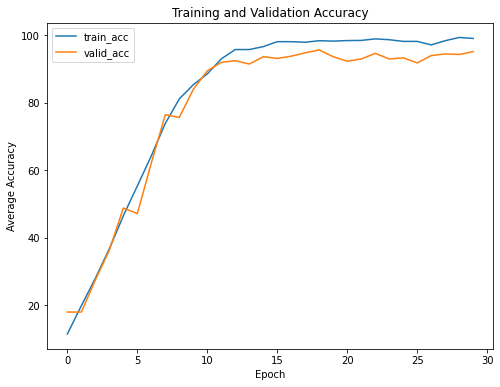

In [ ]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

For [1,128]:

Best epoch: 9 with loss: 0.19 and acc: 95.33%
24.68 total seconds elapsed. 0.82 seconds per epoch.

For [2,512]:

Best epoch: 12 with loss: 0.21 and acc: 96.00%
20.50 total seconds elapsed. 0.68 seconds per epoch.

For [6,5000]:

Best epoch: 18 with loss: 0.27 and acc: 95.67%
75.64 total seconds elapsed. 2.52 seconds per epoch.


from this data it seems the [2,512] training is the best choice out of the 3, with the lowest training time and highest accuracy, the loss and time until best epoch are comparable with [1,128]

Load your best model and Evaluate the model on the test dataset with accuracy metric. You could reuse the previous code.

In [ ]:
######################
### YOUR CODE HERE ###
######################

model = model_128
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

model.cuda()
test_loss = 0.0
test_acc = 0.0

for data, target in test_loader:
  data = data.cuda()
  target = target.cuda()

  output = model(data)
  loss = criterion(output, target)
  test_loss += loss.item() * data.size(0)

  _, pred = torch.max(output, dim=1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))

  test_acc += accuracy.item() * data.size(0)

test_acc = test_acc / len(test_loader.dataset)
print(f'\nModel [1,128] Accuracy: {test_acc}')
#####################
### YOUR CODE END ###
#####################

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=5408, out_features=128, bias=True)
  (fcL): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
  )
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


Model [1,128] Accuracy: 0.9551


# Collaboration policy:
The purpose of student collaboration is to facilitate learning, not to circumvent it.
Studying the material in groups is strongly encouraged. It is also allowed to seek help from other students
in understanding the material needed to solve a particular homework problem, provided no written notes
(including code) are shared, or are taken at that time, and provided learning is facilitated, not circumvented.
The actual solution must be done by each student alone. The presence or absence of any form of help or
collaboration, whether given or received, must be explicitly stated and disclosed in full by all involved.


I talked to Deniz Tabakci, and Andrew Ehebald about the assignment, and wrote the majority of the code from the 400m tutorial on pytorch.  